# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Physical Models of target and interceptor

In [2]:
from models.missile import PhysicalMissleModel
import models.physics as physics
import numpy as np
import math

interceptor_speed = physics.mach_to_ms(5.0)  # Speed of the interceptor in m/s
target_speed = physics.mach_to_ms(4.0)  # Speed of the target in m/s
target = PhysicalMissleModel(velocity=np.array([target_speed / 2, target_speed / 2, 0.0]), max_acc=100 * 9.81, pos=np.array([-5_000.0, -5_000.0, 20_000.0]))
interceptor = PhysicalMissleModel(velocity=np.array([0.0, 0.0, interceptor_speed]), max_acc=100 * 9.81, pos=np.array([0.0, 0.0, 100.0]))

## Environment & Gym

In [ ]:
from environment.environment import MissileEnv, MissileEnvSettings
from pilots.random_evasion_pilot import RandomEvasionPilot
from pilots.constant_acc_pilot import ConstantAccelerationPilot

# target behavior
target_pilot = RandomEvasionPilot(aggression=0.0, trajectory_maintainance=0.5)
# target_pilot = ConstantAccelerationPilot(acc=np.array([0.2, 0.0]))
# target_pilot = None # keep trajectory

settings = MissileEnvSettings()
settings.time_step = 0.05    # Time step for the simulation
settings.realtime = False    # Runs faster than real-time
settings.time_limit = 50.0  # Time-limit for the episode
env = MissileEnv(settings=settings, target=target, interceptor=interceptor, target_pilot=target_pilot)

# Proportional Guidance

In [4]:
from visualization.matplot_viz import MatplotVisualizer

viz = MatplotVisualizer()
        

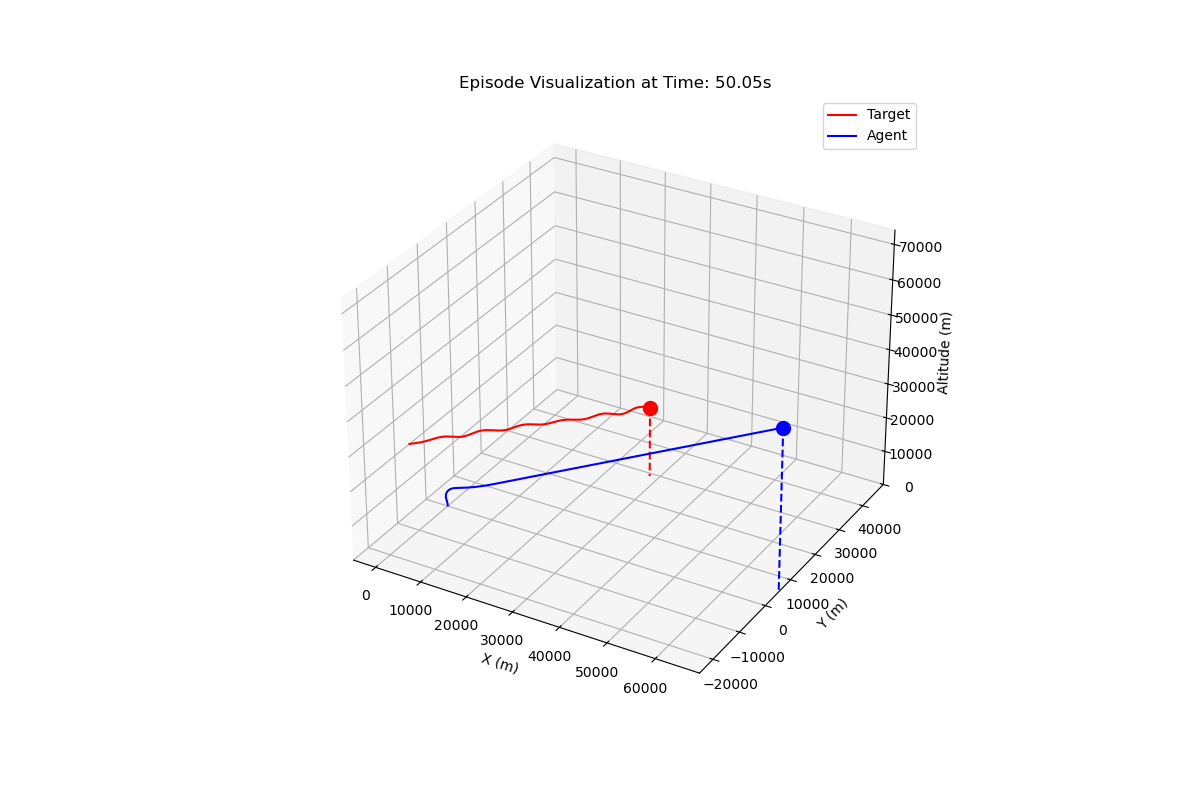

In [13]:
from pilots.proportional_nav_pilot import PlanarProportionalNavPilot, ZemProportionalNavPilot, SpaceProportionalNavPilot
from visualization.matplot_viz import MatplotVisualizer
import time


# setup pilots
proportional_nav_pilot = ZemProportionalNavPilot(max_acc=100*9.81, n=7)


done = False
obs, _ = env.reset()

last_time = time.time()
max_render_fps = 10.0

episode_distances = []
max_sim_time = 0.0

episodes = 1

viz.reset()

for i in range(episodes):
    done = False
    obs, _ = env.reset()
    while not done:
        # get un-normalized observations for the interceptor (environment outputs normalized observations for RL agent)
        obs = env.get_interceptor_observations(settings.time_step).pack()

        # pilot the interceptor using the proportional navigation algorithm
        action = proportional_nav_pilot.step(obs, settings.time_step, interceptor, target)

        obs, reward, done, _, _ = env.step(action)  # Take a step in the environment

    # Record the best distance for this episode
    max_sim_time = max(max_sim_time, env.sim_time)
    distances = [state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()]
    episode_distances.append(min(distances))

    viz.add_episode_data(env.current_episode)

print(f"Best distances over episodes: {episode_distances}")
print(f"Mean best distance: {np.mean(episode_distances):.2f} m")
viz.render(max_sim_time)
# viz.save_playback("prop-nav.gif", max_sim_time, 5.0, 10)

# Reinforcement Learning Agents

## Soft Actor-Critic

In [ ]:
from stable_baselines3 import SAC
from tqdm import tqdm

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./.logs/sac", device="cuda")

In [ ]:
def get_best_distance(episode):
    # get the best distance between the interceptor and the target
    return min([state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()])

print(f"Best distance: {get_best_distance(env.current_episode)} m")

### Training & Evaluation

In [ ]:
# Train until desired results
def eval_model():
    eval_distances = []
    for i in range(10):
        done = False
        while not done:
            obs = env.get_interceptor_observations(settings.time_step).pack()
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, _ = env.step(action)

        best_distance = get_best_distance(env.current_episode)
        eval_distances.append(best_distance)
    
    mean_distance = np.mean(eval_distances)
    print(f"Mean distance: {mean_distance:.2f} m")

    return mean_distance

best_mean_distance = float('inf')
complete = False

while not complete:    
    with tqdm(total=20_000, desc="Training Progress", unit="steps") as pbar:
        model.learn(total_timesteps=20_000, progress_bar=pbar)

    mean_distance = eval_model()
    
    if mean_distance < best_mean_distance:
        best_mean_distance = mean_distance
        model.save(f"best-sac")
        print(f"New best model saved with mean distance: {best_mean_distance:.2f} m")

    model.save(f"latest-sac-{int(mean_distance)}")
    viz.set_episode_data(env.current_episode)

    if mean_distance < 50.0:
        complete = True
        print(f"Training complete! Mean distance: {mean_distance:.2f} m")

### Inference

In [ ]:
# Extract reward components over time
def create_reward_plot(infos):
    times = list(infos.keys())
    dist_rewards = [info["dist-reward"] for info in infos.values()]
    closing_rate_rewards = [info["closing-rate-reward"] for info in infos.values()]
    event_rewards = [info["event-reward"] for info in infos.values()]
    action_punishments = [info["action-punishment"] for info in infos.values()]
    ground_penalties = [info["ground-penality"] for info in infos.values()]
    rewards = [info["reward"] for info in infos.values()]

    # Create the plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plt.plot(times, dist_rewards, label="Distance Reward")
    plt.plot(times, closing_rate_rewards, label="Closing Rate Reward")
    plt.plot(times, event_rewards, label="Event Reward")
    plt.plot(times, action_punishments, label="Action Punishment")
    plt.plot(times, ground_penalties, label="Ground Penalty")
    plt.plot(times, rewards, label="Total Reward", linestyle='--', color='black', linewidth=2.5)

    plt.xlabel("Time (s)")
    plt.ylabel("Reward Components")
    plt.title("Reward Components Over Time")
    plt.legend()
    plt.grid(True)
    
    return plt

def render_reward_plot(infos):
    plt = create_reward_plot(infos)
    plt.show()
    plt.show(block=False)

def save_reward_plot(infos, filename):
    plt = create_reward_plot(infos)
    plt.savefig(filename)
    plt.close()

In [ ]:
# load best model
model = SAC.load("best-sac", env=env)

obs, _ = env.reset()
done = False
infos = {}
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, _, info = env.step(action)
    infos[env.sim_time] = info

render_reward_plot(infos)
viz.set_episode_data(env.current_episode)
# viz.render(env.sim_time)

# Results

## Evaluate

In [ ]:
best_distances = []

viz.reset()
max_sim_time = 0.0
episodes = 1

for i in range(episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, _, _ = env.step(action)
        
    distances = [state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()]
    best_distances.append(min(distances))

    max_sim_time = max(max_sim_time, env.sim_time)
    viz.add_episode_data(env.current_episode)

best_distance = min(best_distances)
worst_distance = max(best_distances)
mean_distance = np.mean(best_distances)
print(f"Best Distance: {best_distance:.2f} m | Worst Distance: {worst_distance:.2f} | Mean Distance: {mean_distance:.2f} m")

# render
# viz.render(env.sim_time)
viz.save_playback("sac.gif", max_sim_time, 5.0, 10)

## Save and Playback

In [ ]:
for id, interceptor_state in env.current_episode.interceptors.items():
    distances = [state.distance for time , state in interceptor_state.states.all.items()]
    best_distance = min(distances)
    print (f"Interceptor {id} best distance: {best_distance:.2f} m")

viz.set_episode_data(env.current_episode)
viz.save_playback("output.gif", env.sim_time, 5.0, 5)

## Plot Distance over time

In [ ]:
# get all distances from the interceptor to the target
distances = {time: state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()}

import matplotlib.pyplot as plt
import numpy as np

times = list(distances.keys())
distance_values = list(distances.values())

plt.figure(figsize=(10, 6))
plt.plot(times, distance_values, label="Distance over Time")

# Find the minimum value and its corresponding time
min_distance = min(distance_values)
min_time = times[distance_values.index(min_distance)]

# Add a label for the minimum value
plt.scatter(min_time, min_distance, color='red', label=f"Min Distance: {min_distance:.2f} m")
plt.text(min_time, min_distance, f"({min_time:.2f}, {min_distance:.2f})", color='red', fontsize=10)

plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Interceptor to Target Distance Over Time")
plt.legend()
plt.grid(True)
plt.show()